In [1]:
import pandas as pd
from pygam import LogisticGAM, s, te
from pygam import LinearGAM, s, f, te
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import os
import sys

# Define the current working directory
cwd = os.getcwd()

# load the data
data = pd.read_csv(cwd + '/health_data.csv')
data

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


In [2]:
# Create a working copy to avoid modifying the original data
df = data.copy()

# Define th list of categoriacl variables
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert inf to NaN, although according to the data description there are no Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaNs, although according to the data description there are no NaNs
df.dropna(inplace=True)

# Drop the id column and -1
df.drop(['id', 'Unnamed: 0'], axis=1, inplace=True)

# Convert age in days
df['age'] = df['age']/365.25

# Filter for impossible values for height, weight, ap_hi, ap_lo
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 240)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]
df = df[df['age'] <100]

# Add a new column for the BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Filter for reasonable values for BMI
df = df[(df['BMI'] > 6) & (df['BMI'] < 70)]

# Convert all categorical variables to strings,
# this will be undone at a later stage (remember to do it before the model)
df[categorical] = df[categorical].astype(str)

# Reset index for... resons?
df.reset_index(drop=True, inplace=True)

# Put the cardio column at the end
df = df[[c for c in df if c not in ['cardio']] + ['cardio']]

# Here's the resulting df
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


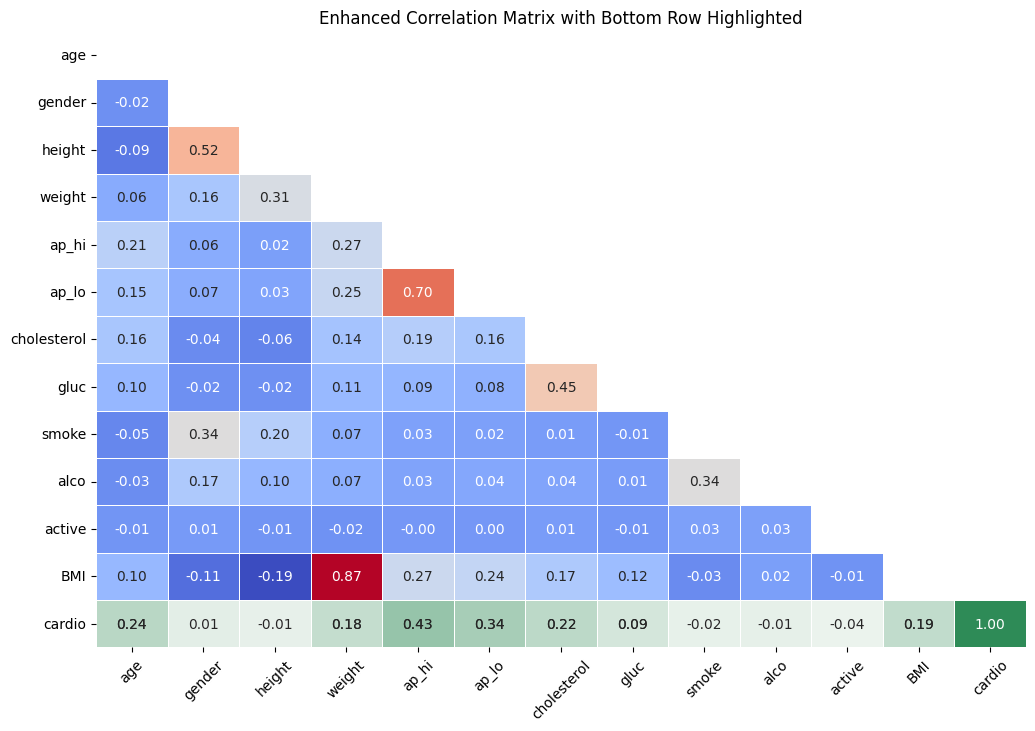

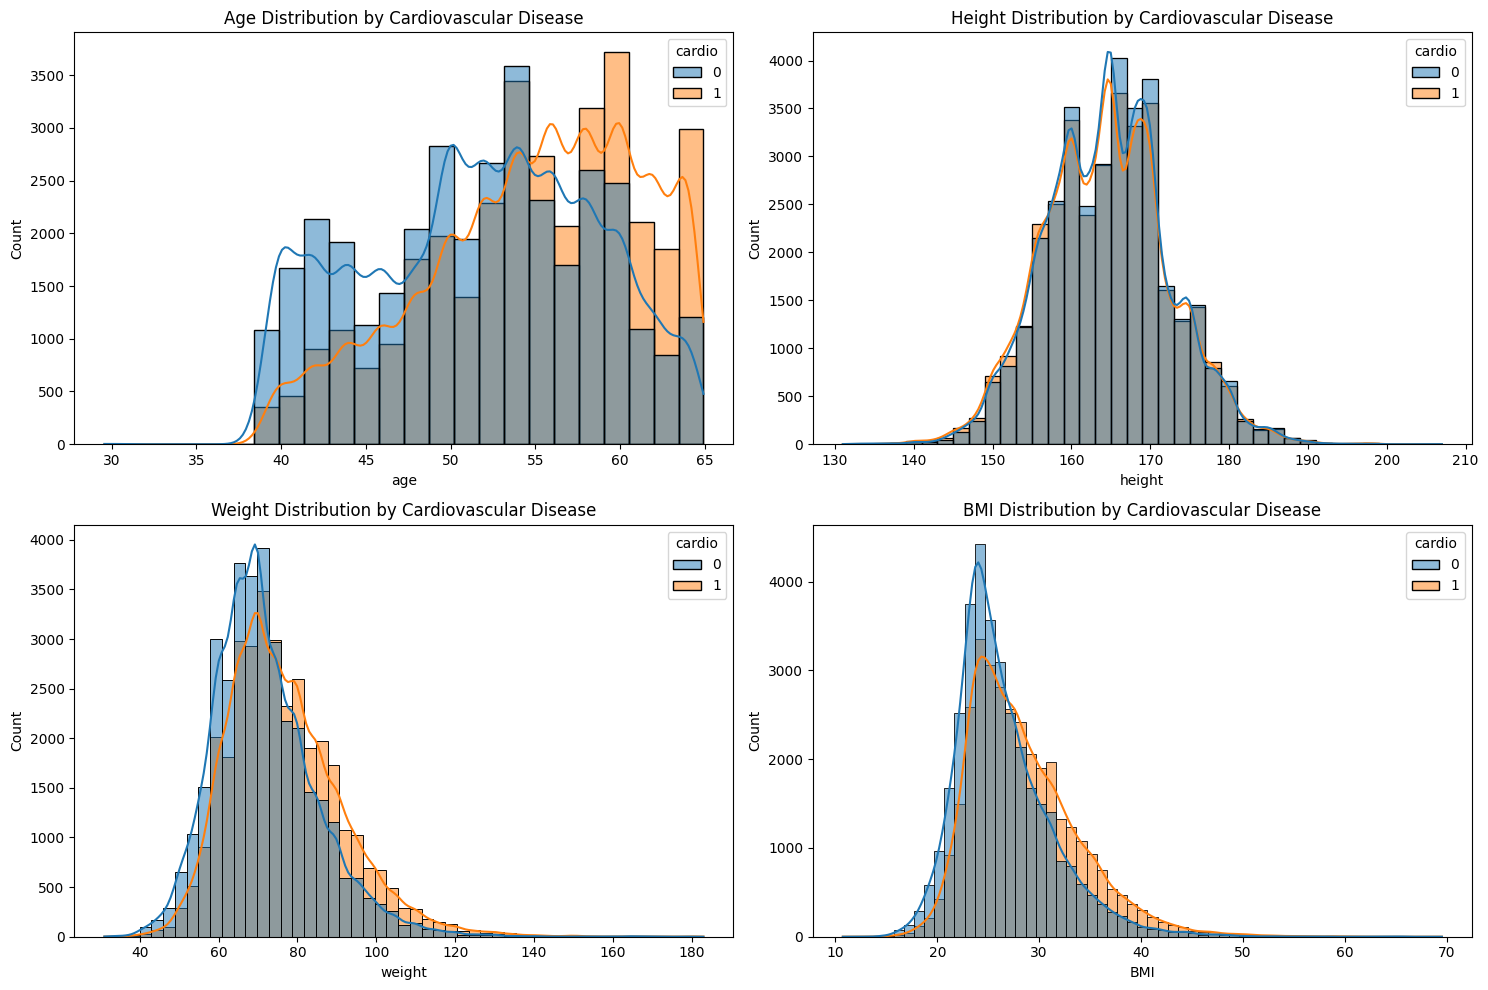

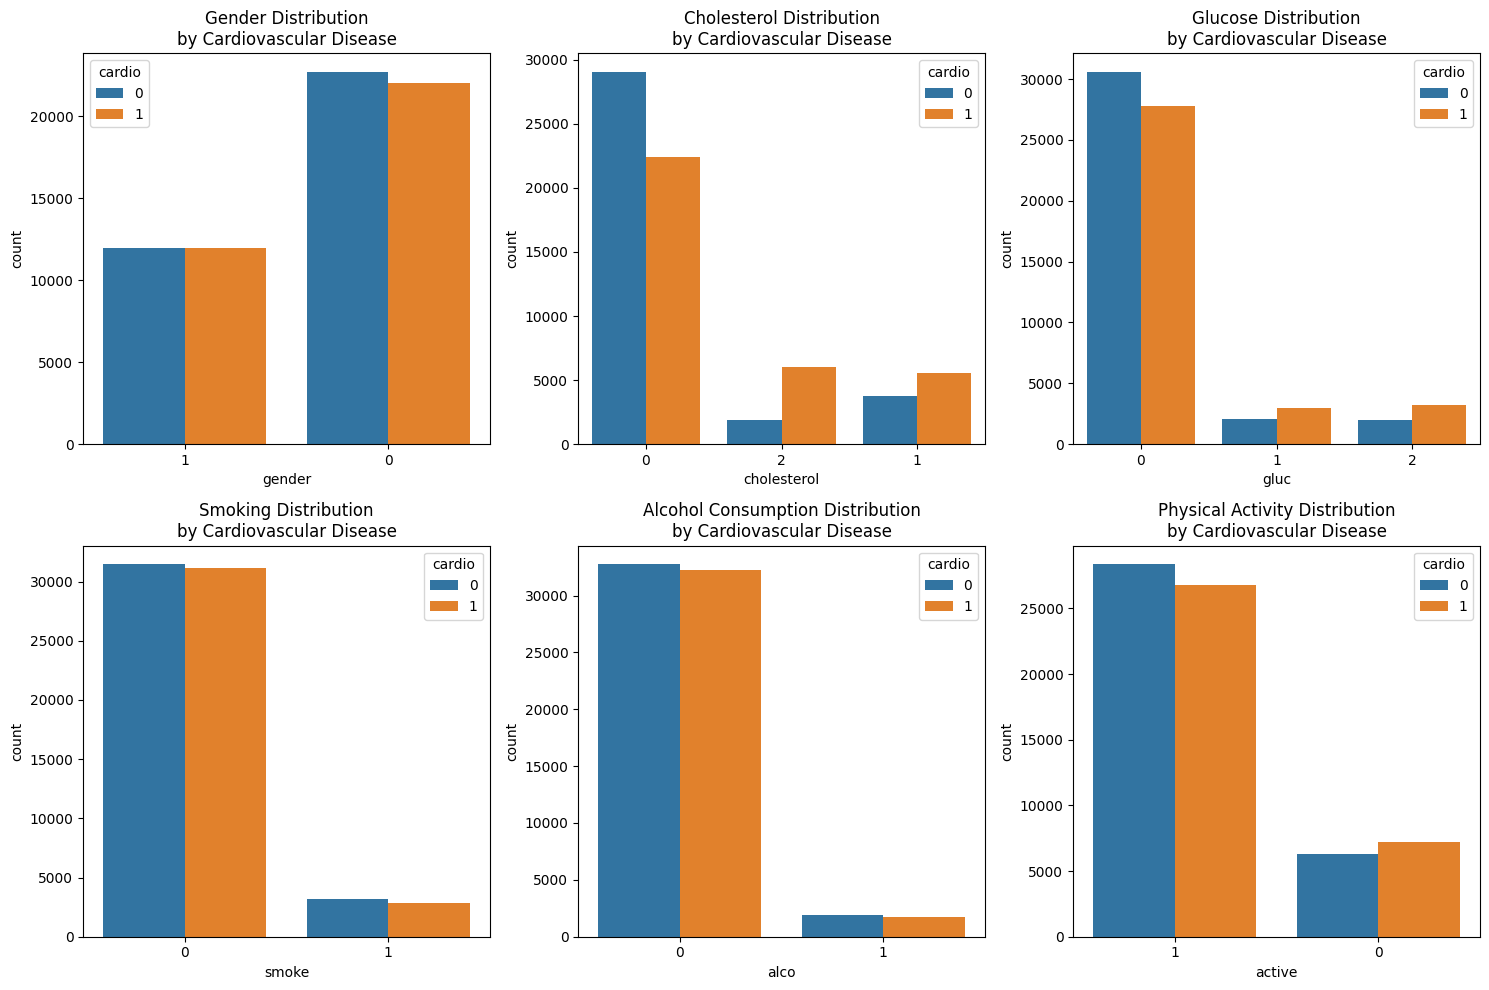

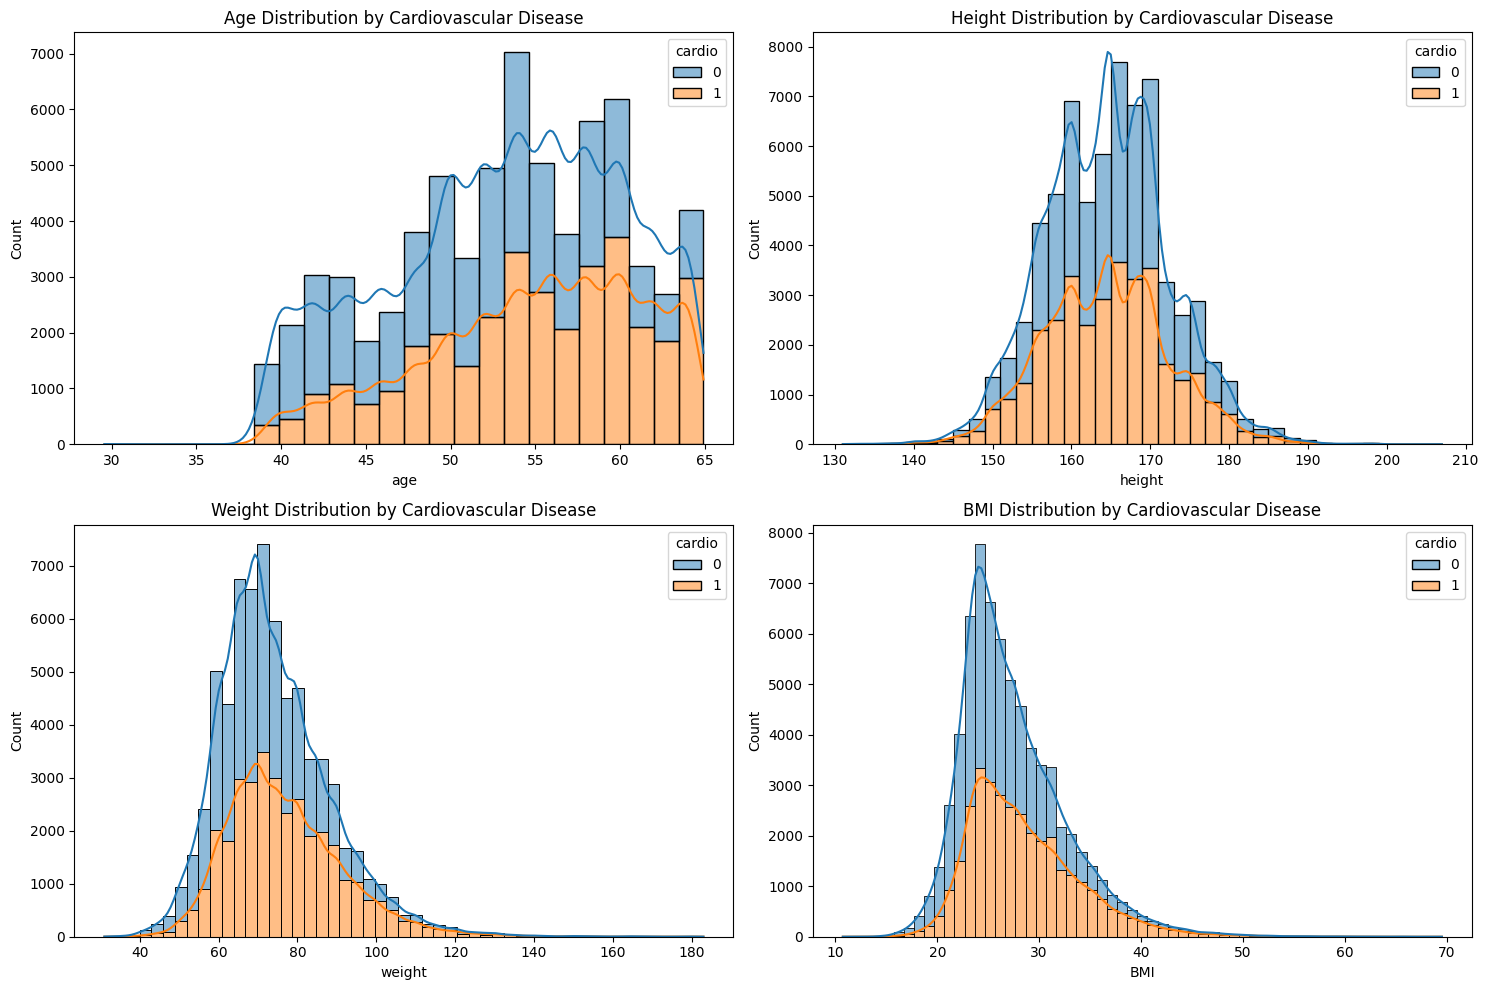

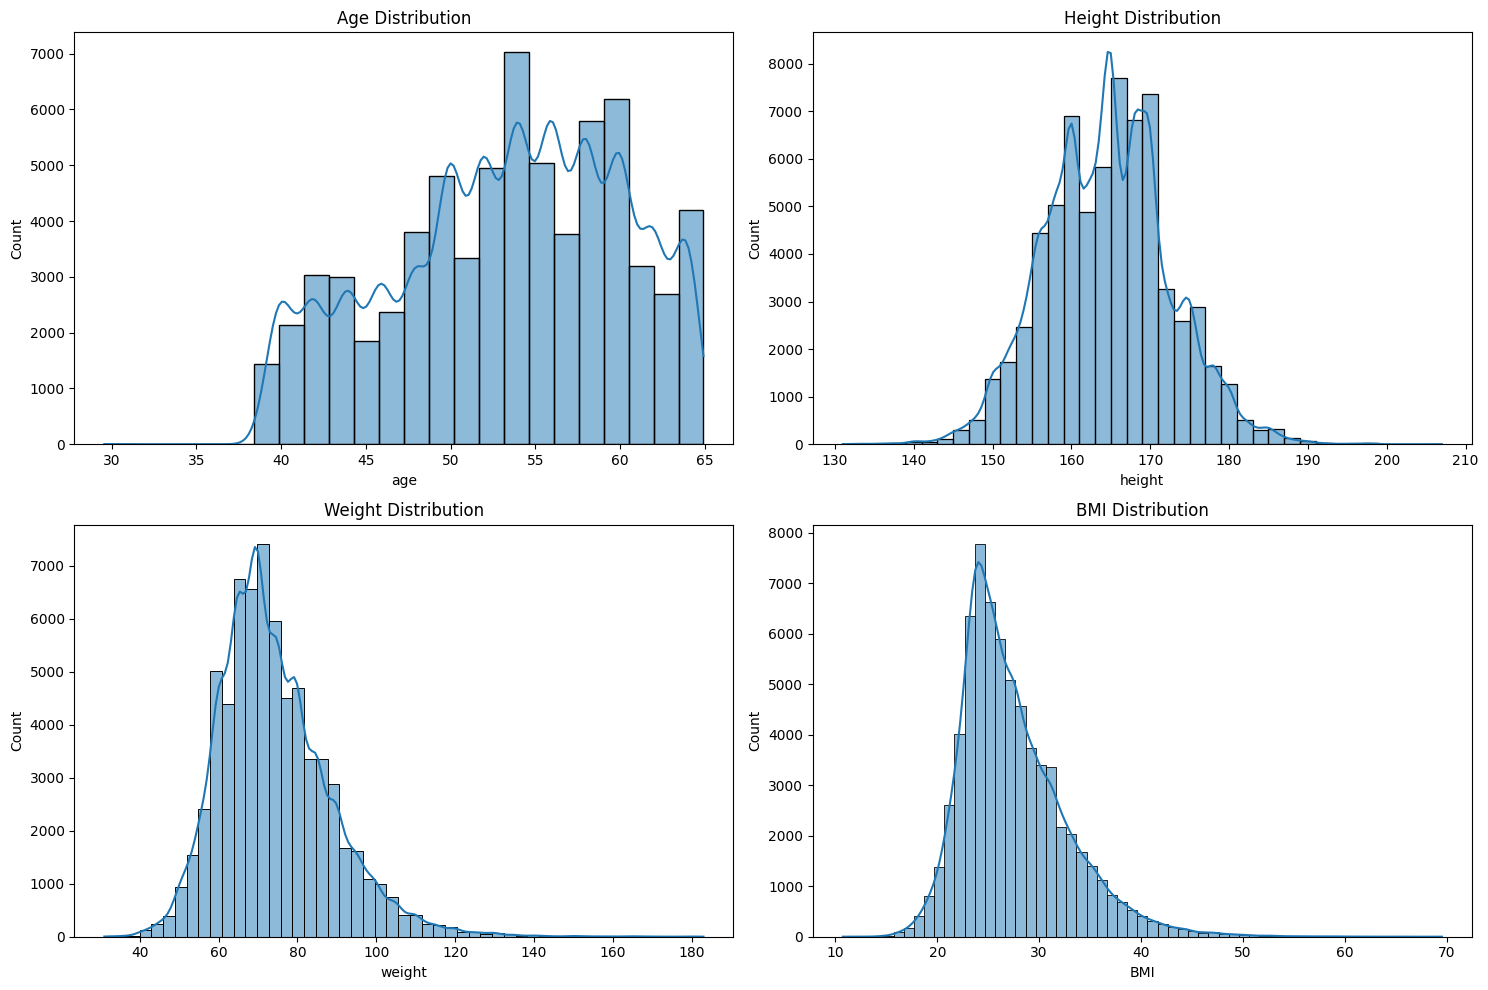

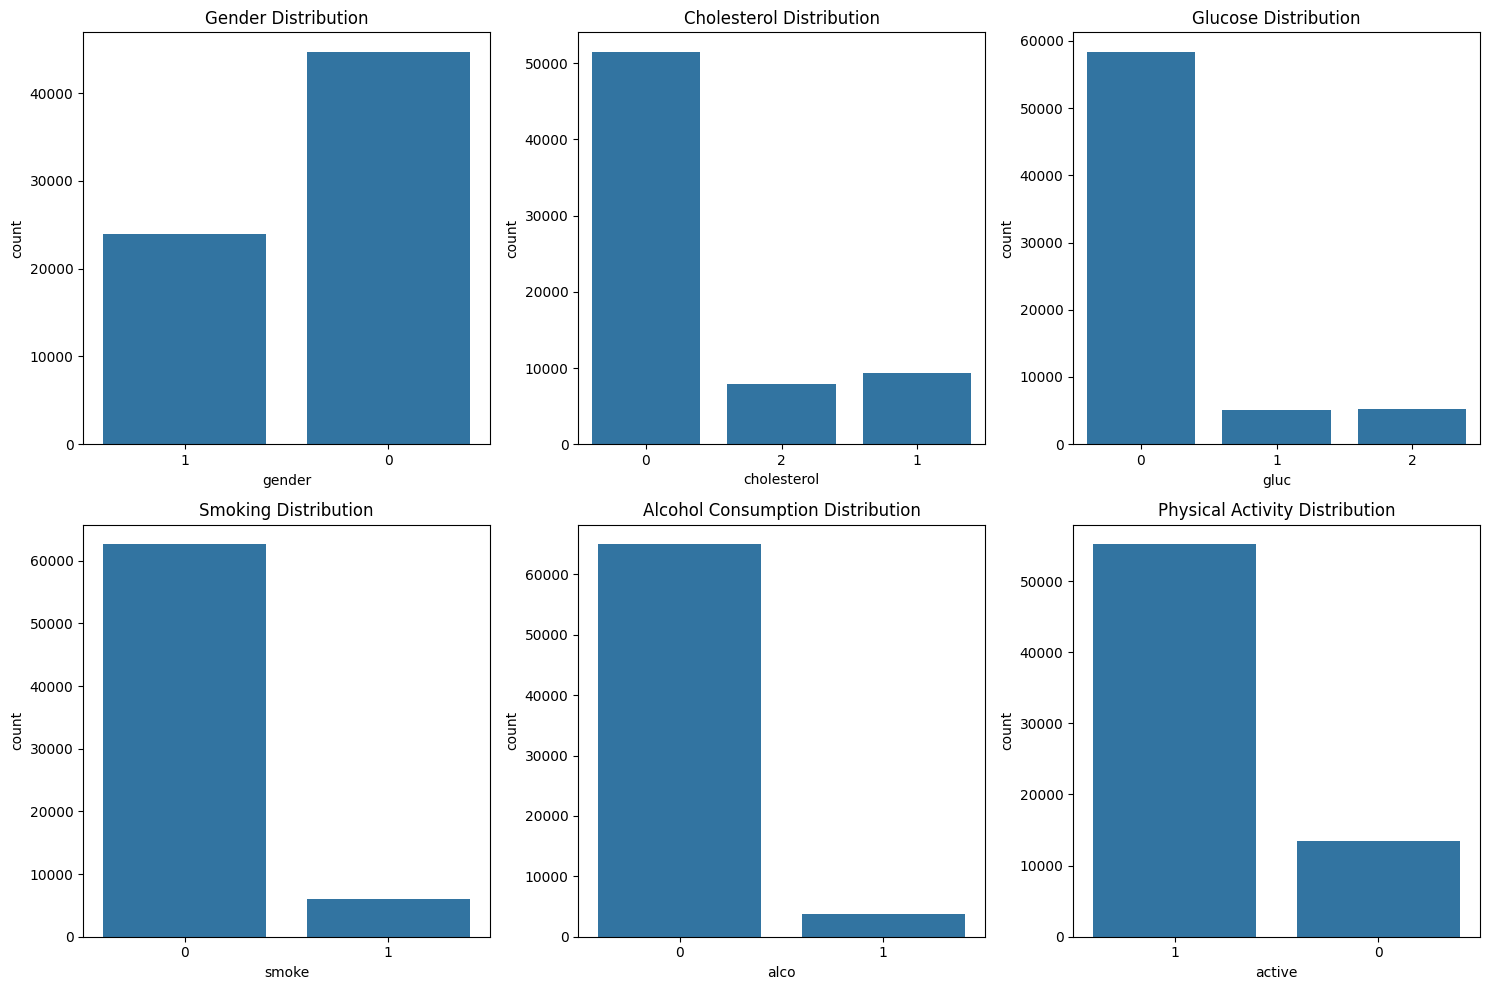

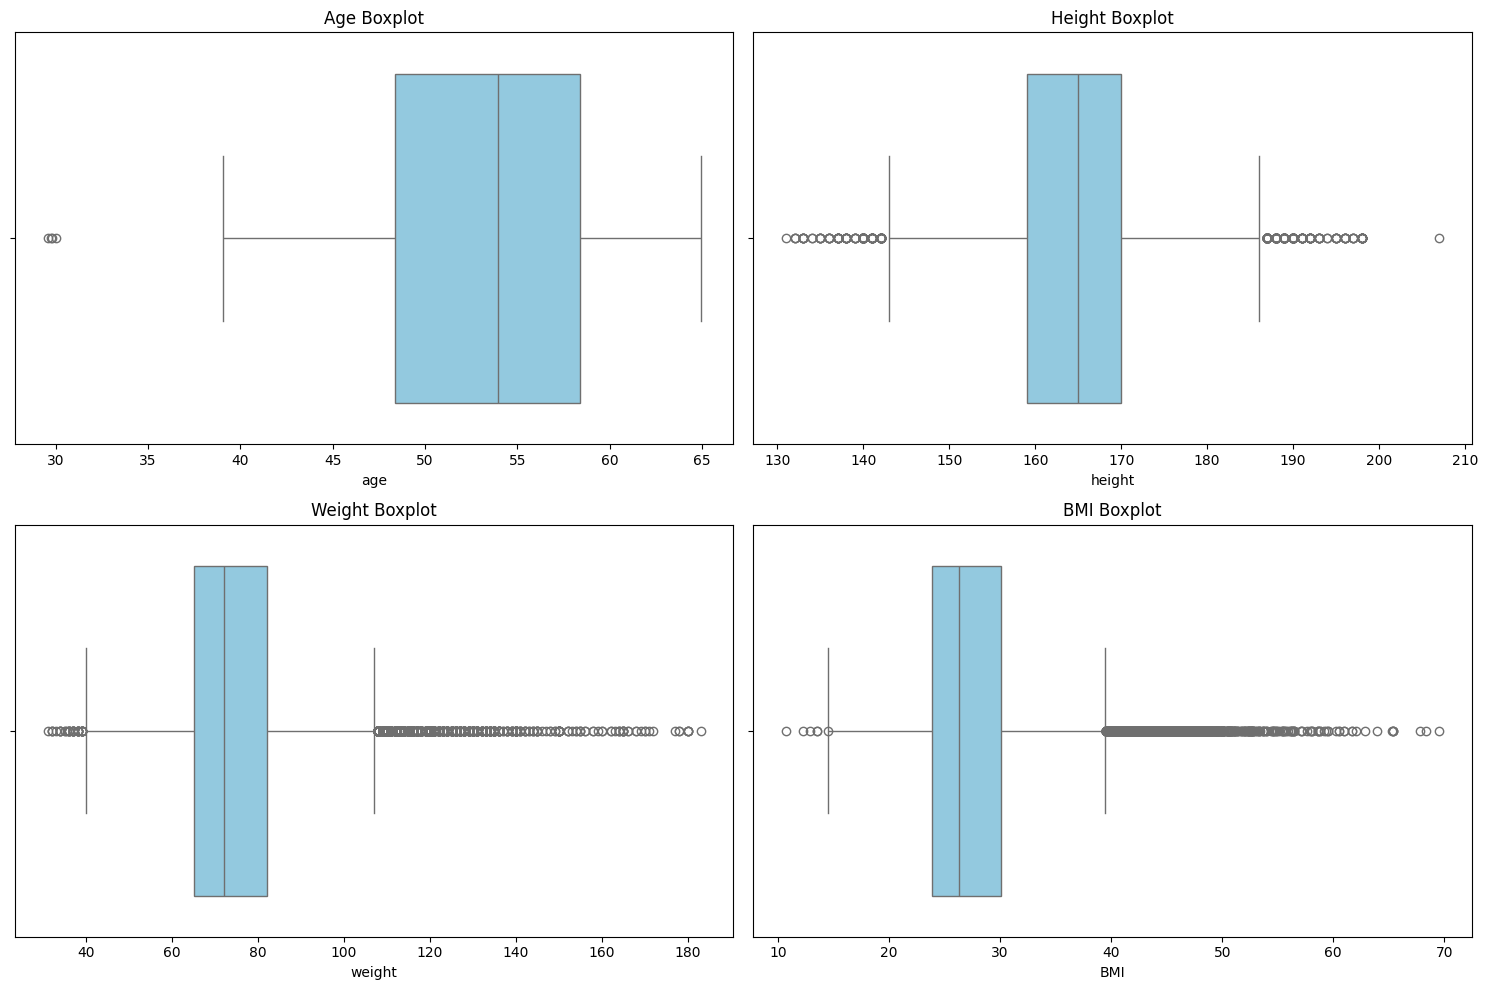

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'BMI', 'cardio'],
      dtype='object')

In [3]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

####################################################
## CORRELATION MATRIX WITH HIGHLIGHTED BOTTOM ROW ##
####################################################

plt.figure(figsize=(12, 8))
# Creating a mask for the upper triangle
mask_upper = np.triu(np.ones_like(df.corr(), dtype=bool))
# Creating a mask for all but the bottom row (for highlighting)
mask_not_bottom = np.ones_like(df.corr(), dtype=bool)
mask_not_bottom[-1, :] = False  # Unmask the bottom row
# Plot the main heatmap with the upper triangle masked
sns.heatmap(df.corr(), annot=True, mask=mask_upper, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
# Overlay with the bottom row highlighted
# Adjust 'highlight_cmap' to change the highlight color
highlight_cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, mask=mask_not_bottom, cmap=highlight_cmap, fmt=".2f", linewidths=.5, cbar=False)
plt.xticks(rotation=45)
plt.title('Enhanced Correlation Matrix with Bottom Row Highlighted')
plt.show()

#################
## OTHER PLOTS ##
#################

# Plot the distribution of the target variable according to the numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plotting the distribution of the target variable according to the categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', hue='cardio', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution\nby Cardiovascular Disease')
sns.countplot(x='cholesterol', hue='cardio', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution\nby Cardiovascular Disease')
sns.countplot(x='gluc', hue='cardio', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution\nby Cardiovascular Disease')
sns.countplot(x='smoke', hue='cardio', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution\nby Cardiovascular Disease')
sns.countplot(x='alco', hue='cardio', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution\nby Cardiovascular Disease')
sns.countplot(x='active', hue='cardio', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution\nby Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plot the numerical distribution like a population pyramid
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0], multiple='stack')
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1], multiple='stack')
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0], multiple='stack')
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1], multiple='stack')
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

#Variables values distributions
#numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution')
sns.histplot(df_eda, x='height', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution')
sns.histplot(df_eda, x='weight', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution')
sns.histplot(df_eda, x='BMI', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution')
plt.tight_layout()
plt.show()
#categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution')
sns.countplot(x='cholesterol', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution')
sns.countplot(x='gluc', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution')
sns.countplot(x='smoke', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution')
sns.countplot(x='alco', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution')
sns.countplot(x='active', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution')
plt.tight_layout()
plt.show()

#Boxplots for numerical variables
# Variables values distributions - Numerical variables (including boxplots)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# Boxplots for numerical variables
sns.boxplot(x='age', data=df_eda, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Age Boxplot')
sns.boxplot(x='height', data=df_eda, ax=ax[0, 1], color='skyblue')
ax[0, 1].set_title('Height Boxplot')
sns.boxplot(x='weight', data=df_eda, ax=ax[1, 0], color='skyblue')
ax[1, 0].set_title('Weight Boxplot')
sns.boxplot(x='BMI', data=df_eda, ax=ax[1, 1], color='skyblue')
ax[1, 1].set_title('BMI Boxplot')
plt.tight_layout()
plt.show()

# Show the column names of dfù
df.columns

In [4]:
# Assuming 'df' is your DataFrame and 'categorical' is a list of categorical variables

# Create a copy of the cleaned dataset to use for logistic regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

# Get the dummies
df_with_dummies = pd.get_dummies(df_regression, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_with_dummies['intercept'] = 1.0

# Fit the logistic regression model
model = sm.Logit(df_with_dummies['cardio'], df_with_dummies.drop(columns=['cardio'])).fit()

# Display the model's summary
print(model.summary())

# Drop certain features and fit the model again
df_dropped_stuff = df.copy()
df_dropped_stuff[categorical] = df_dropped_stuff[categorical].astype(int)
df_dropped_stuff = df_dropped_stuff.drop(['gluc', 'alco', 'height', 'ap_lo'], axis=1).copy()
df_dummies = pd.get_dummies(df_dropped_stuff, drop_first=True)
df_dummies['intercept'] = 1.0
model_dropped = sm.Logit(df_dummies['cardio'], df_dummies.drop(columns=['cardio'])).fit()
print(model_dropped.summary())

# Drop 'gender' and fit the model again
df_dropped_stuff_nogend = df.copy()
df_dropped_stuff_nogend[categorical] = df_dropped_stuff_nogend[categorical].astype(int)
df_dropped_stuff_nogend = df_dropped_stuff_nogend.drop(['gluc', 'alco', 'height', 'ap_lo', 'gender'], axis=1).copy()
df_dummies_nogend = pd.get_dummies(df_dropped_stuff_nogend, drop_first=True)
df_dummies_nogend['intercept'] = 1.0
model_dropped_nd = sm.Logit(df_dummies_nogend['cardio'], df_dummies_nogend.drop(columns=['cardio'])).fit()
print(model_dropped_nd.summary())


# Perform the likelihood ratio test
lr_test = model.llf - model_dropped_nd.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof = len(model.params) - len(model_dropped_nd.params)

# p-value
from scipy.stats import chi2
p_value = chi2.sf(lr_test, dof)

print('Likelihood ratio test statistic between the full and cut model:', lr_test)
print('Degrees of freedom:', dof)
print('p-value:', p_value)

# Fit the null model
null_model = sm.Logit(df_with_dummies['cardio'], df_with_dummies['intercept']).fit()
print(null_model.summary())

# Perform the likelihood ratio test
lr_test_null = model_dropped_nd.llf - null_model.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof_null = len(model_dropped_nd.params) - len(null_model.params)

# p-value
p_value_null = chi2.sf(lr_test_null, dof_null)

print('Likelihood ratio test statistic between the cut and null model:', lr_test_null)
print('Degrees of freedom:', dof_null)
print('p-value:', p_value_null)

Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        18:17:30   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

## Classification Tree

In [5]:
from sklearn import tree

In [6]:
# Convert all categorical variables to integers
# Create a copy of the cleaned dataset to use for logistic regression
df_tree = df.copy()
df_tree[categorical] = df[categorical].astype(int)
df_tree

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X = df_tree.drop('cardio', axis=1) # Features
y = df_tree['cardio'] # Target variable

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)


In [8]:
clf = tree.DecisionTreeClassifier(random_state=42, criterion='gini', splitter='best',max_depth=10, min_samples_leaf= 500)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


In [9]:
from sklearn.metrics import accuracy_score, classification_report
# Step 6: Evaluate the model's performance
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# You can also print a detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7272886195443156
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8669
           1       0.75      0.67      0.71      8492

    accuracy                           0.73     17161
   macro avg       0.73      0.73      0.73     17161
weighted avg       0.73      0.73      0.73     17161



In [10]:
import graphviz
df_features = df_tree.drop('cardio', axis=1)
features = df_features.columns 
classes = ['Not heart disease','heart disease']

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=classes,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")


'decision_tree_graphivz.png'

### Pre Pruning

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_leaf': [i for i in range(100, 500, 50)]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)


print(gcv.best_params_)

{'max_depth': 8, 'min_samples_leaf': 100}


In [12]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
print(classification_report(y_test, y_pred))

Train score 0.7370823620823621
Test score 0.7274634345317872
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8669
           1       0.75      0.67      0.71      8492

    accuracy                           0.73     17161
   macro avg       0.73      0.73      0.73     17161
weighted avg       0.73      0.73      0.73     17161



In [13]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


Train Confusion matrix


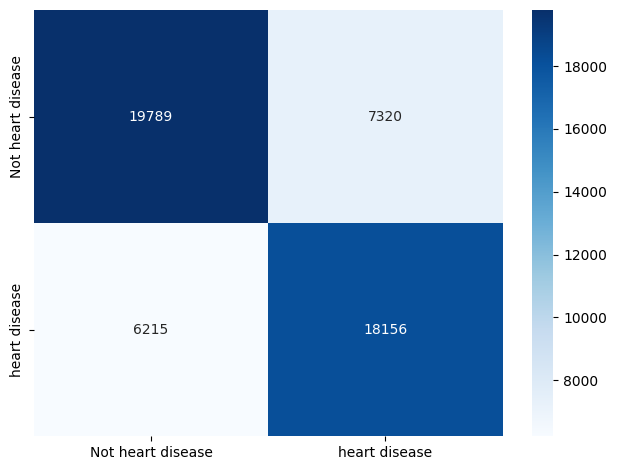

Test Confusion matrix


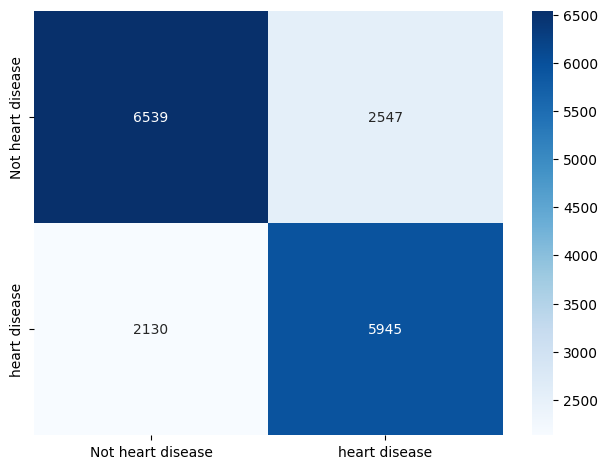

In [14]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [15]:
#GAM 
# Create a copy of the cleaned dataset to use for linear regression
df_gam = df.copy()

# Convert all categorical variables to integers
df_gam[categorical] = df_gam[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_gam.drop('cardio', axis=1)
y = df_gam['cardio']

# Fit a GAM model
gam = LogisticGAM().fit(X, y)

# Make predictions on the same dataset
y_pred = gam.predict(X)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Print a summary of the GAM model
print(gam.summary())

# Get the dummies
df_with_dummies = pd.get_dummies(X, drop_first=True)

# Convert categorical variables to dummies
#X = pd.get_dummies(X, columns=categorical, drop_first=True)

# Create a GAM model
gam = LogisticGAM(s(0, n_splines=5) + s(1, n_splines=5) + s(2, n_splines=5) + s(3, n_splines=5) + s(4, n_splines=5) + s(5, n_splines=5) + s(6, n_splines=5) + f(7))

# Fit the model to the data
gam.fit(X, y)

# Plot the estimated functions for each feature
plt.figure(figsize=(12, 8))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.plot(XX[:, term.feature], pdep, label=f'Feature {term.feature}')
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)

plt.xlabel('Feature Values')
plt.ylabel('Partial Dependence')
plt.legend()
plt.show()

###########################
#Plot alternative(?)#
###########################
# Plot the estimated functions for each feature
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    term = gam.terms[i + 1]  # Skip the intercept term
    XX = gam.generate_X_grid(term=i + 1)
    pdep, confi = gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label=f'Feature {term.feature}', color=f'C{i}')  # Use different colors for each feature
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {term.feature}')
    ax.set_ylabel('Partial Dependence')
    ax.legend()

plt.tight_layout()
plt.show()


Mean Squared Error: 0.1890
R-squared: 0.2439


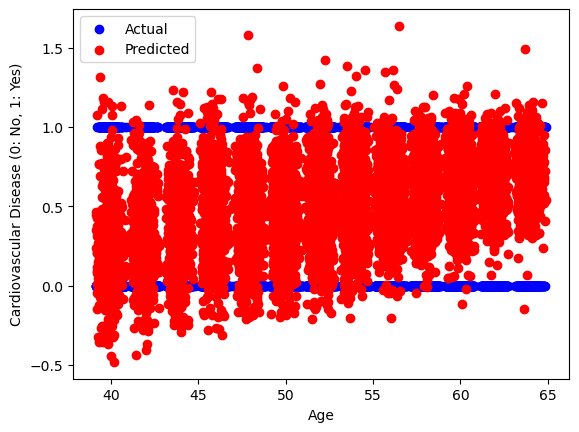

Mean Squared Error: 0.1890
R-squared: 0.2439


In [ ]:
#Polynomial regression w/ train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_poly = df.copy()

# Convert all categorical variables to integers
df_poly[categorical] = df_poly[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_poly.drop('cardio', axis=1)
y = df_poly['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the degree of the polynomial (you can adjust this)
degree = 2

# Use PolynomialFeatures to create polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a linear regression model with polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

# Visualize the predictions vs. actual values
plt.scatter(X_test['age'], y_test, color='blue', label='Actual')
plt.scatter(X_test['age'], y_pred, color='red', label='Predicted')
plt.xlabel('Age')
plt.ylabel('Cardiovascular Disease (0: No, 1: Yes)')
plt.legend()
plt.show()


# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')
plt.show()

NameError: name 'term' is not defined

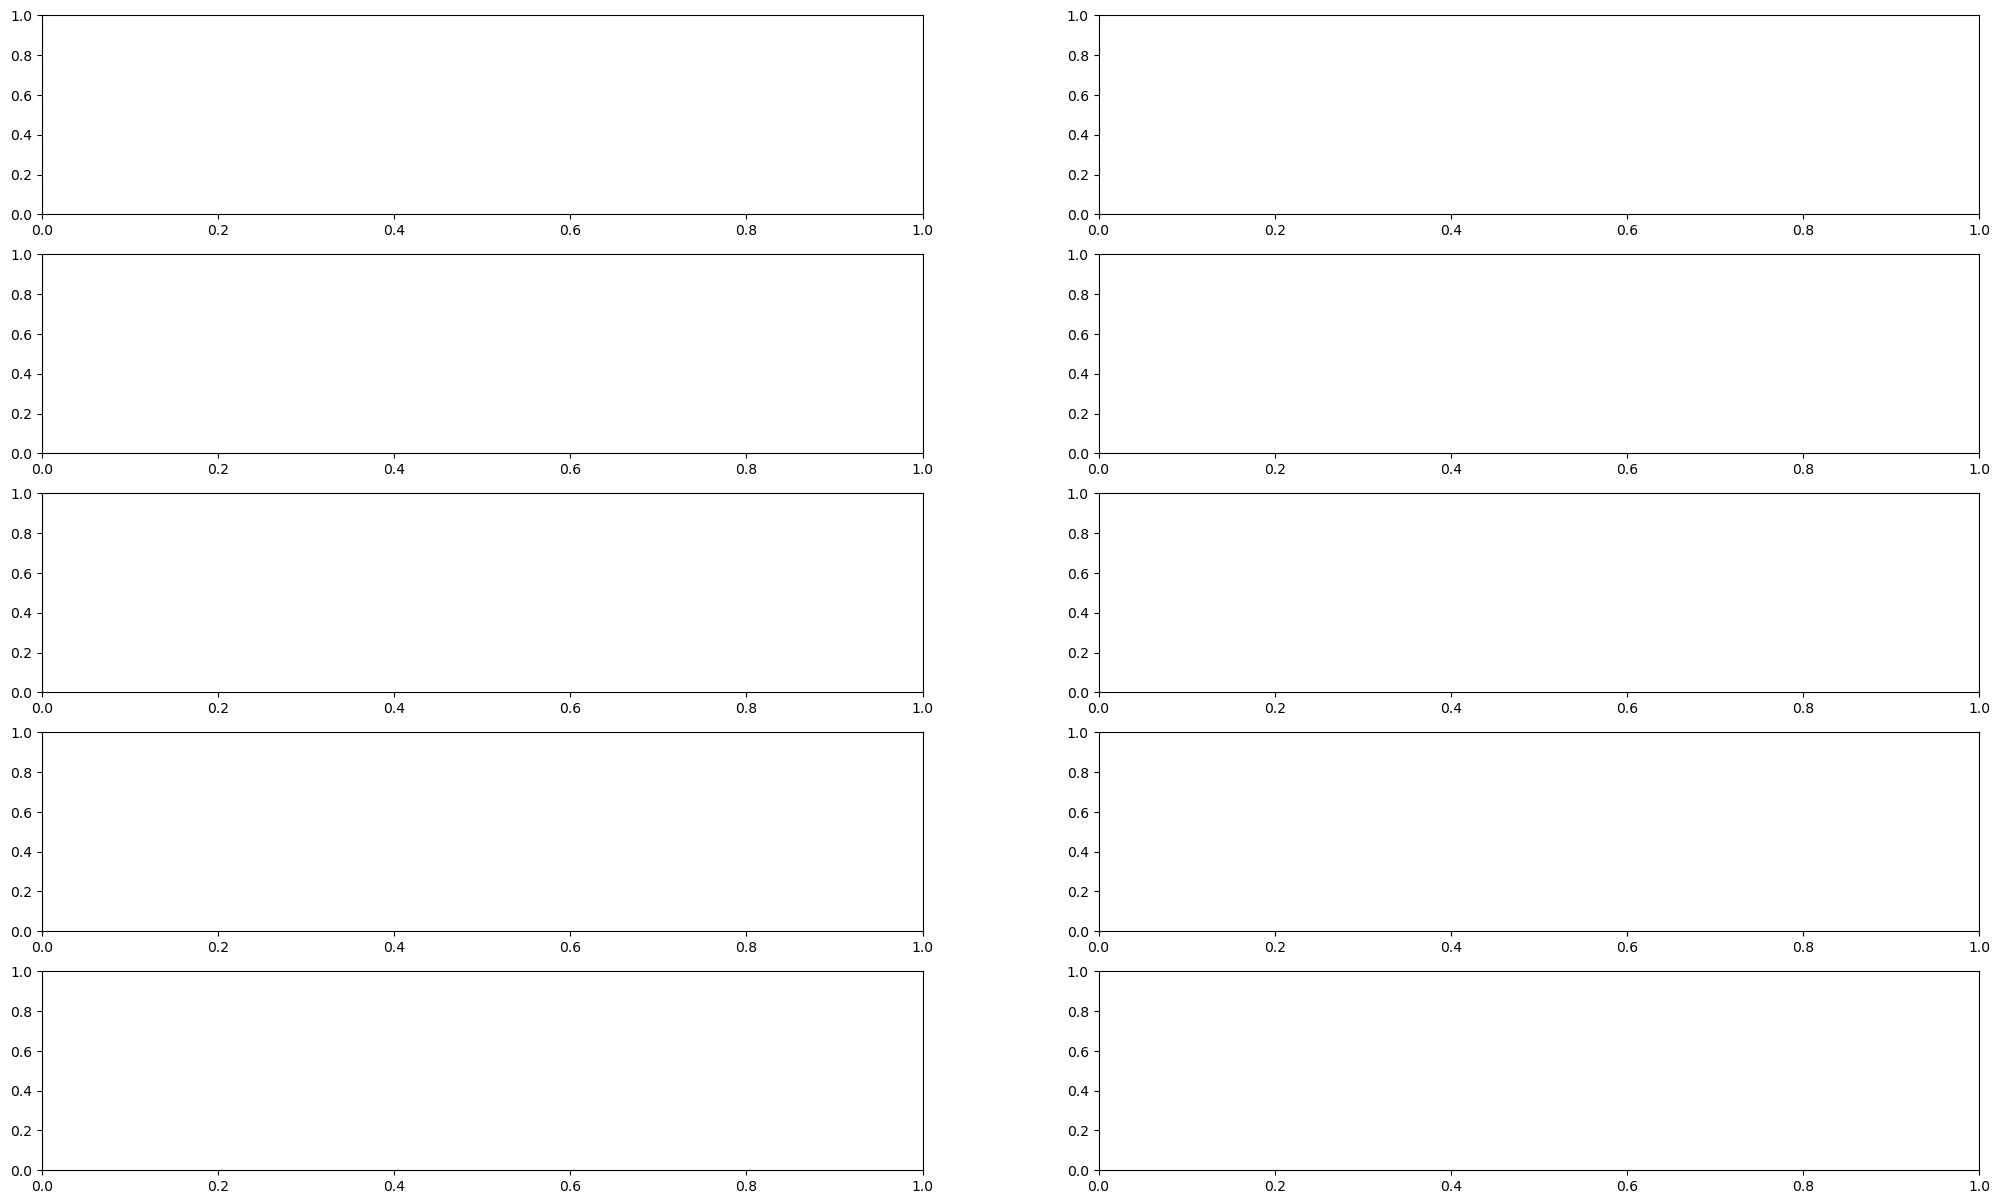

In [ ]:
#Polynomial regression w/ train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_poly = df.copy()

# Convert all categorical variables to integers
df_poly[categorical] = df_poly[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_poly.drop('cardio', axis=1)  # Exclude the target variable
y = df_poly['cardio']

# Convert categorical variables to dummies
#X = pd.get_dummies(X, columns=categorical, drop_first=True)

# Generate polynomial features manually
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Create a GAM model with polynomial terms
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + s(8) + s(9) + s(10))  # Adjust for your specific features

# Fit the model to the data
gam.fit(X_poly, y)

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 15))

term.feature = ['prova']

# Plot the estimated functions for each feature
for i, ax in enumerate(axes.flatten()):
    term = gam.terms[i + 1]  # Skip the intercept term
    XX = gam.generate_X_grid(term=i + 1)
    pdep, confi = gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep)
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {term.feature}')
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()